<a href="https://colab.research.google.com/github/pk19505/IPB-CW2023/blob/main/IPB_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [0/100], Loss: 0.6040697693824768
Epoch [10/100], Loss: 0.01692293956875801
Epoch [20/100], Loss: 0.005828497000038624
Epoch [30/100], Loss: 0.005379443056881428
Epoch [40/100], Loss: 0.004171876702457666
Epoch [50/100], Loss: 0.0031011884566396475
Epoch [60/100], Loss: 0.0023098865058273077
Epoch [70/100], Loss: 0.0017948764143511653
Epoch [80/100], Loss: 0.0013562907697632909
Epoch [90/100], Loss: 0.0010602292604744434


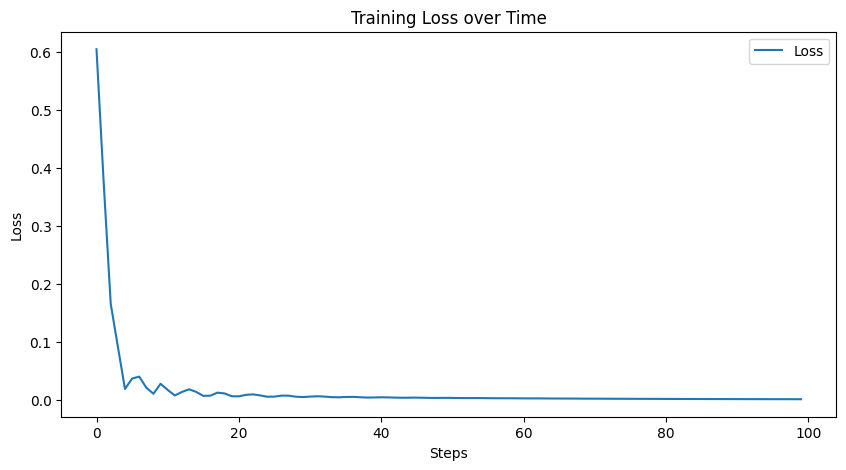

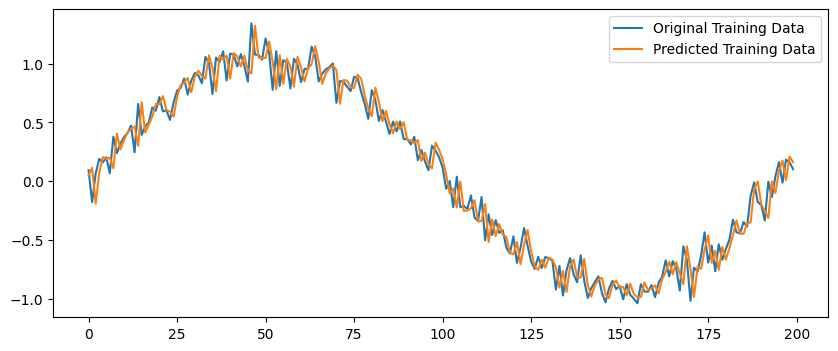

Test Loss: 0.0007233658689074218


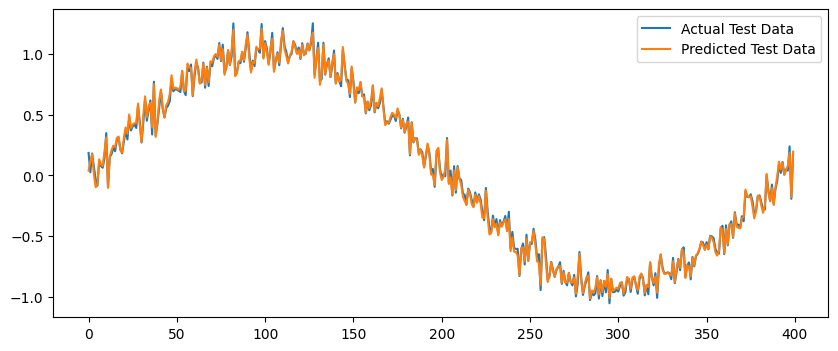

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


def generate_data(sequence_length, num_sequences):
    #loop through number of sequences
  for _ in range(num_sequences):
    #create random signal
    signal = np.linspace(0, 2 * np.pi, sequence_length)
    #random noise
    noise = np.linspace(0, 0.1, sequence_length)
    #generate sequence using signal + noise
    #sequence = ([np.sin(signal) + np.random(signal) + noise])
    sequence = ([np.sin(signal) + np.random.normal(0, 0.1, sequence_length) + noise])

    #shift the input data to create the target data
    shift=1
    shifted_data = np.roll(sequence, shift, axis=1)
  #convert both input and target to tensor floats
  i = torch.tensor(sequence,dtype=torch.float32).unsqueeze(-1)
  j = torch.tensor(shifted_data,dtype=torch.float32).unsqueeze(-1)
  #print(np.shape(i))
  #print(np.shape(j))
  return i, j


#RNN network with predictive coding
class PD_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super(PD_RNN, self).__init__()
        #set up layer, forward pass from input to hidden
        self.fc1 = nn.RNN(input_size, hidden_size, batch_first=True)
        #hidden state to output connection
        self.fl= nn.Linear(hidden_size, output_size)
        #layer for feedback mechanism
        self.bl = nn.Linear(output_size, hidden_size)

    def forward(self, x):
          #determine the batch_size from input
          batch_size = x.size(0)
          #hidden state initialization
          hidden = torch.zeros(1, batch_size, self.fc1.hidden_size)
          #perform forward pass and return output and the updated hidden state
          out, hidden = self.fc1(x, hidden)
          #get the predicted output
          prediction = self.fl(out)

          #prediction error calculation
          error_signal = x - prediction
          #adjust the model's predictions using the error signal
          feedback = self.bl(error_signal)
          #print("hidden shape:", hidden.shape)
          #print("feedback shape:", feedback.shape)
          #print("error_signal shape:", error_signal.shape)
          hidden = hidden + feedback

          return prediction, error_signal




#training function
def train_model(model, input_data, target_data, num_epochs):
  #Adam optimizer for updating model weights, with learning rate of 0.05
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  #mean squared error loss used
    criterion = nn.MSELoss()
    #iterate over number of epochs
    loss_total = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        #predict output
        output, _ = model(input_data)
        #calculate loss given the output and target data
        loss = criterion(output, target_data)
        #add losses together
        loss_total.append(loss.item())
        #backprop to calculate gradients
        loss.backward()
        #update model's weights using the gradients
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
    plt.figure(figsize=(10,5))
    plt.title("Training Loss over Time")
    plt.plot(loss_total,label='Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_predictions(model, input_data):
    model.eval()
    with torch.no_grad():
        predictions, _ = model(input_data)
        plt.figure(figsize=(10, 4))
        plt.plot(input_data.numpy().flatten(), label='Original Training Data')
        plt.plot(predictions.numpy().flatten(), label='Predicted Training Data')
        plt.legend()
        plt.show()

# Generate input and target data
input_data, target_data = generate_data(200,1) # 200 length, 50 sequence
#Testing dataset
eval_data, eval_target_data = generate_data(400, 1)
# Initialize & train model
model = PD_RNN(1, 42, 1)  # (input size,hidden size,output size)
train_model(model, input_data, target_data, 100) #epochs = 100
plot_predictions(model, input_data)


# Evaluate the model on the new testing set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Evaluate the model on eval set
#plot eval vs predictions
  model.eval()
  with torch.no_grad():
          eval_predictions, _ = model(eval_data)
          plt.figure(figsize=(10, 4))
          plt.plot(eval_data.numpy().flatten(), label='Original')
          plt.plot(eval_predictions.numpy().flatten(), label='Predicted')
          plt.legend()
          plt.show()
          test_loss = nn.MSELoss()(eval_predictions, eval_target_data)

Epoch [0/50], Loss: 0.4881332516670227, Learning Rate: 0.01
Epoch [10/50], Loss: 0.029551880434155464, Learning Rate: 0.01
Epoch [20/50], Loss: 0.014699507504701614, Learning Rate: 0.01
Epoch [30/50], Loss: 0.005832604132592678, Learning Rate: 0.001
Epoch [40/50], Loss: 0.006027508527040482, Learning Rate: 0.0001


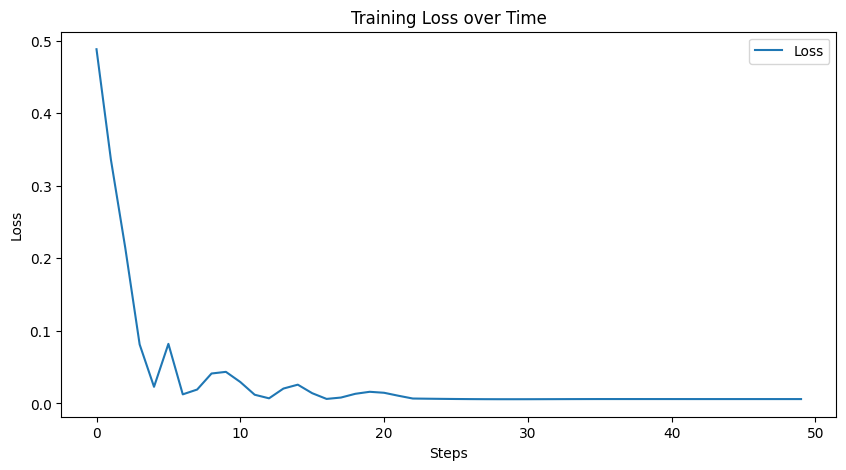

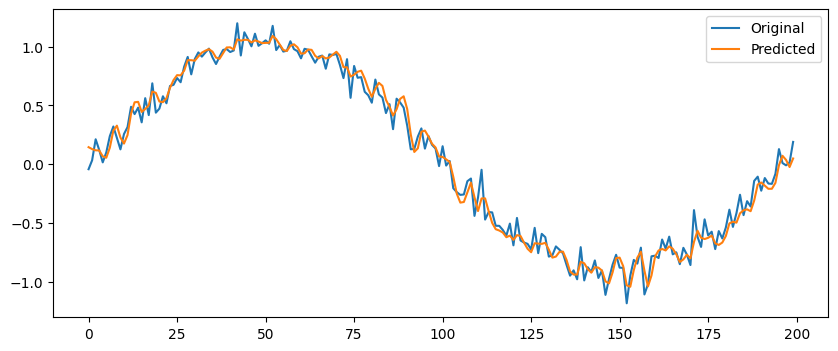

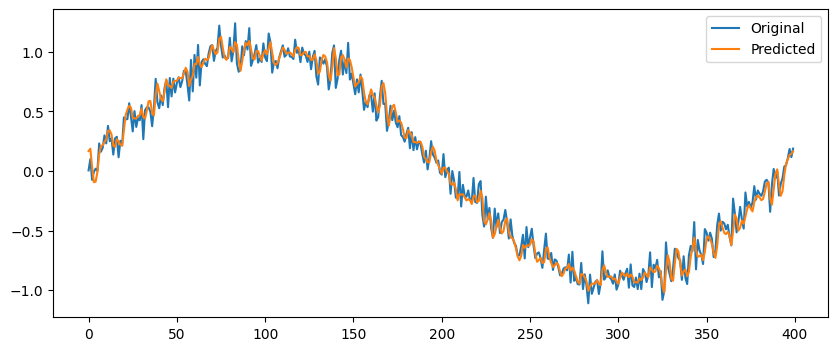

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


def generate_data(sequence_length, num_sequences):
    #create sequence of sequence_length
        for _ in range(num_sequences):
          #create random signal
          signal = np.linspace(0, 2 * np.pi, sequence_length)
          #random noise
          noise = np.linspace(0, 0.1, sequence_length)
          #generate sequence using signal + noise
          #sequence = ([np.sin(signal) + np.random(signal) + noise])
          sequence = ([np.sin(signal) + np.random.normal(0, 0.1, sequence_length) + noise])
          #shift the sequence to create the target data
          shift=1
          shifted_data = np.roll(sequence, shift, axis=1)
          #return tensor floats for input and target tada
          i = torch.tensor(sequence,dtype=torch.float32).unsqueeze(-1)
          j = torch.tensor(shifted_data,dtype=torch.float32).unsqueeze(-1)

        return i, j


class Leaky_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super(Leaky_RNN, self).__init__()
        #set up layer, forward pass from input to hidden
        self.fc1 = nn.RNN(input_size, hidden_size, batch_first=True)
        #hidden state to output connection
        self.fl = nn.Linear(hidden_size, output_size)
        #layer for feedback mechanism
        self.bl = nn.Linear(output_size, hidden_size)
        #generate leaky factor between 0 and 1
        leaky_factor = np.random.rand()
        #create leaky factor attribute
        self.leakyf = leaky_factor

    def forward(self, x):
        #determine the batch_size from input
        batch_size = x.size(0)
        #hidden state initialization
        hidden = torch.zeros(1, batch_size, self.fc1.hidden_size)
        #perform forward pass and return output and the updated hidden state
        out, new_hidden = self.fc1(x, hidden)
        #get the predicted output
        prediction = self.fl(out)
        #prediction error calculation
        error_signal = x - prediction
        #adjust the model's predictions using the error signal
        feedback = self.bl(error_signal)
        #find scaled hidden state and complementary term
        scaled_hidden_state = self.leakyf * hidden
        complementary_term = 1 - self.leakyf
        hidden = scaled_hidden_state + (1 - self.leakyf) * (new_hidden + feedback)
        return prediction, error_signal


def train_model(model, input_data, target_data, num_epochs):
  #Adam optimizer for updating model weights, with learning rate of 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience = 5)
#mean squared error loss used
    criterion = nn.MSELoss()
    #iterate over number of epochs
    loss_total=[]
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        #predict output
        output, _ = model(input_data)
        #calculate loss given the output and target data
        loss = criterion(output, target_data)
        #pass loss to scheduler
        scheduler.step(loss)
        current_lr = optimizer.param_groups[0]['lr']
        loss_total.append(loss.item())
        #backprop to calculate gradients
        loss.backward()
        #update model's weights using the gradients
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, Learning Rate: {current_lr}')
    plt.figure(figsize=(10,5))
    plt.title("Training Loss over Time")
    plt.plot(loss_total,label='Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



def plot_predictions(model, input_data):
    model.eval()
    with torch.no_grad():
        predictions, _ = model(input_data)
        plt.figure(figsize=(10, 4))
        plt.plot(input_data.numpy().flatten(), label='Original')
        plt.plot(predictions.numpy().flatten(), label='Predicted')
        plt.legend()
        plt.show()

# Generate input and target data, then generate evaluation data
input_data, target_data = generate_data(200, 1) # 200 length, 1 sequence
#evaluation dataset
eval_data, eval_target_data = generate_data(400, 1)

# Initialize & train model
model = Leaky_RNN(1, 32, 1)  # (input size,hidden size,output size)
train_model(model, input_data, target_data, 50) # epochs = 50

# Visualize predictions
plot_predictions(model, input_data)

# Evaluate the model on eval set
#plot eval vs predictions
model.eval()
with torch.no_grad():
        eval_predictions, _ = model(eval_data)
        plt.figure(figsize=(10, 4))
        plt.plot(eval_data.numpy().flatten(), label='Original')
        plt.plot(eval_predictions.numpy().flatten(), label='Predicted')
        plt.legend()
        plt.show()
        test_loss = nn.MSELoss()(eval_predictions, eval_target_data)




